# 27-734 Homework 8: Periodic Table Data Science

## *Due electronically May 6 at midnight*
## Laura (Kai Sze) Luk ; got extension from Prof. Holm

In this homework, we will continue the data-science based analysis of the Periodic Table that we began in Group Exercise 0. For this homework, you will need:

* The data science conda environment installed (**env_cross_platform_ds.yaml**). 
* **ElementsData.csv**: Comma-separated-variable file containing elemental property data.
* **ElementsDataSubset.csv**: CSV file containing property data for a subset of the elements.
* The correlation coefficient results from Group Exercise 0.

You will turn in a PDF of this completed notebook.

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import copy

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

## Analysis 1: Multiple linear regression


In [5]:
# Load the data in the file ElementsData.csv as a pandas dataframe 'ptdf'
ptdf = pd.read_csv("ElementsData.csv")


In [6]:
# (2 pts)
# Check that the data has loaded correctly by displaying the first 5 rows of the table
firstFive = ptdf.head(5)
print(firstFive)


  Name  Group  Electro-negativity  Electrical Conductivity S/m  \
0   Li      2                0.98                 1.080000e+07   
1   Be      3                1.57                 3.130000e+07   
2    B      1                2.04                 1.000000e-04   
3    C      1                2.55                 6.100000e+04   
4   Na      2                0.93                 2.100000e+07   

   Thermal Conductivity W/mK  Specific Heat J/kgK  Molecular Weight  \
0                       84.7               3580.0                 3   
1                      201.0               1830.0                 4   
2                       27.4               1030.0                 5   
3                      129.0                709.0                 6   
4                      141.0               1230.0                11   

   AtomicRadius A  Density Solid g/cc  Ionization Potential ev  
0            2.05               0.534                    5.392  
1            1.40               1.848         

Note that the element group numbers in ElementsData.csv represent the following:

1 – Nonmetals<br>
2 – Alkali metals<br>
3 – Alkaline earth metals<br>
4 – Transition metals<br>
5 – Metals<br>
6 – Halogen <br>
7 – Rare earth metals<br>
8 – Noble gas

Now, let’s do some machine learning on this data using multiple linear regression. 

Based on the results from Group Exercise 0, you should have foudn that the feature that is most highly correlated with electronegativity is the ionization potential.

(2 pts) What is the correlation coefficient R between electronegativity and ionization potential? 
** the correlation coefficient,  R = 0.832435. **

In [103]:
# Perform linear regression between electronegativity (the target) and the ionization
# potential (the feature) using sklearn linear_model.
ptdfCopy = ptdf.copy(True)
df_slice = ptdfCopy[['Electro-negativity', 'Ionization Potential ev']]
X_ioniz = np.array(df_slice['Ionization Potential ev']).reshape(-1, 1)
y_electro = np.array(df_slice['Electro-negativity']).reshape(-1, 1)
regr = linear_model.LinearRegression()
regr.fit(X_ioniz, y_electro)

# (2 pts)
# Report the R^2 coefficient for this fit. 
r2 = regr.score(X_ioniz, y_electro)
print(r2)

0.6929473522538139


Note that the R^2 fitting coefficient (a.k.a. the coefficient of determination) equals the correlation coefficient R squared. Take the square root of R^2 to calculate the correlation coefficient |R|. Does it match your previous result from the correlation analysis? 
** Yes, it matches my previous result from the correlation analysis. The R^2 fitting coefficient, R^2 = 0.692947. Then, taking the (positive) square root of that value gives us, 0.832434. This matches the result from the correlation analysis because R = 0.832435. **

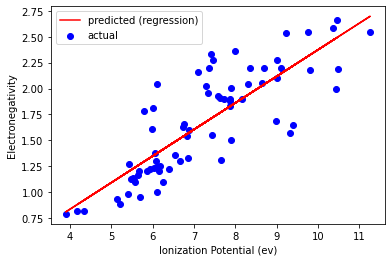

In [82]:
# (4 pts)
# Plot the actual electronegativity vs. the ionization potential as blue circles
# and the predicted electronegativity vs. the ionization potential (the regression line) as a red line. 
# Be sure to label the axes and provide a legend.
plt.scatter(X_ioniz, y_electro, color = 'b', label = 'actual')
plt.plot(X_ioniz, regr.predict(X_ioniz), color = 'r', label = 'predicted (regression)')
plt.xlabel('Ionization Potential (ev)')
plt.ylabel('Electronegativity')
plt.legend()
#plt.show()

In [22]:
# (2 pts)
# Print the slope and intercept of the regression line
slope = regr.coef_
print(slope[0][0])
intercept = regr.intercept_
print(intercept[0])


0.2563477814818043
-0.18869456395062412


Ionization potential was the feature most strongly correlated with electronegativity, but there are six other features. Let's use multiple linear regression to determine whether the six remaining features, taken together, give as good a prediction as the ionization potential alone.

In [104]:
# Perform multiple linear regression between electronegativity (target) and the six remaining features,
# (excluding the ionization potential).

# Note that the sklearn linear_model can perform multiple regression if the x values are an array 
# with multiple columns. Thus, you can use the same python code as above, if you modify the feature
# vector to be a six-column array.

# So, assemble the relevent physical properties data into a numpy array via ptdf.values. 
# (Be sure to exclude the element name and group from the feature array, as well as the 
# electronegativity and ionization potential.)\
ptdfCopy1 = ptdf.copy(True)
df_slice6 = ptdfCopy1[['Electro-negativity', 'Electrical Conductivity S/m', 'Thermal Conductivity W/mK', 'Specific Heat J/kgK', 'Molecular Weight', 'AtomicRadius A', 'Density Solid g/cc']]
X_feat = np.array(df_slice6.values[:, 1:])
y_electro6 = np.array(df_slice6.values[:, :1])

regr6 = linear_model.LinearRegression()
regr6.fit(X_feat, y_electro6)

# (2 pts)
# print the predicted electronegativity of Li according to this model
pred = regr6.predict(X_feat)
print(pred[0][0])


0.7862913781043837


As we discussed in class, the $R^2$ coefficient indicates the amount of variance in the data that is captured by the curve fit for a pairwise regression. However, when we move to multiple regression, adding additional independent variables (features) mathematically guarantees that $R^2$ will increase compared to the pairwise value, even if the fit isn't actually improving.

To adjust for this, we define the adjusted $R_{adj}^2$ coefficient, which increases only if includeing the new feature improves the model more than would be expected by chance. It decreases when a feature improves the model less than expected by chance. 

$$R_{adj}^2 = 1 - \frac{(1-R^2)(n-1)}{n-k-1}$$

where *n* is the number of data points (here, the number of elements) and *k* is the number of features per data point.

Note that for a pairwise regression, $R_{adj}^2$ = $R^2$ and so for any regression $R_{adj}^2$ ≤ $R^2$

In [57]:
# (2 pts)
# Report the adjusted mean square error Radj^2 for the six-feature multiple regression.
n = len(pred)
k = 6
r22 = regr6.score(X_feat, y_electro6)
rAdj = 1 - (((1 - r22) * (n - 1)) / (n - k - 1))
print(rAdj)

0.7618861694687462


(2 pts) Which features give a better prediction of electronegativity: ionization potential alone or all the rest of the features together? 
** The adjusted R^2 value for the pairwise regression between electronegativity and ionization potential is 0.688561 (with R^2 value of 0.692947).
The adjusted R^2 value for the 6-feature multiple regression is 0.761886 (with R^2 value of 0.782008).
Since the adjusted R^2 value is larger for the 6-feature multiple regression, compared to that of the pairwise regression, the 6-feature regression gives a better prediction for electronegativity. **

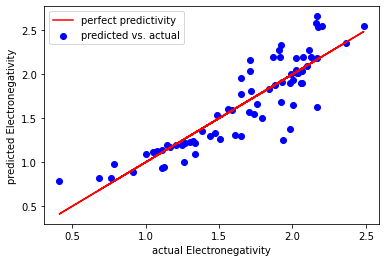

In [84]:
# (4 pts)
# For your regression model, plot the predicted vs. actual electronegativity data (blue circles) 
# and the predicted = actual line (red line), which would represent perfect predictivity.
# Be sure to label axes and provide a legend.


plt.scatter(regr6.predict(X_feat), y_electro6, color = 'b', label = 'predicted vs. actual')
plt.plot(regr6.predict(X_feat), regr6.predict(X_feat), color = 'r', label = 'perfect predictivity')
plt.xlabel('actual Electronegativity')
plt.ylabel('predicted Electronegativity')
plt.legend()
#plt.show()

## Analysis 2: Principal component analysis (PCA)

Now, let’s use principal component analysis (PCA) to visualize the dataset and look for clusters. 

For the remaining tasks, we will restrict the dataset to the rare earth metals (group 7) and transition metals (group 4); these data are contained in the **ElementsDataSubset.csv** file. 

In [108]:
# Load the data in the file ElementsDataSubset.csv as a pandas dataframe 'ptdf2'
ptdf2 = pd.read_csv("ElementsDataSubset.csv")

# Assemble all of the physical properties data into a numpy array via ptdf2.values. 
# Note you should not include the element symbol or the group number as features.
prop = ptdf2.values
properties = copy.deepcopy(prop)
features = properties[:, 2:]

In [73]:
# (2 pts)
# To avoid effects due to the different units and magnitudes for each feature, 
# it is essential to normalize the data by scaling each feature to have zero mean and unit variance.
# Use the sklearn StandardScaler function to do this to your array of features.
scaler = StandardScaler()
featuresT = scaler.fit_transform(features)


In [88]:
# (2 pts)
# Now perform PCA on the feature set and print out a list of the variance explained
# by each PCA dimension (ordered from most variance to least)
pca = PCA()
featuresNew = pca.fit_transform(featuresT)
variance = pca.explained_variance_
print(list(variance))

[4.164197057550353, 2.5596413427952864, 1.017206041312451, 0.24531865024676916, 0.11585689245408044, 0.06306585529435135, 0.03034495674080629, 0.004369203605898408]


In [87]:
# (2 pts)
# For the first PCA dimension, print out the vector of feature components, i.e. the eigenvector
eigenvector1 = pca.components_[0]
print(eigenvector1)

[ 0.46053537  0.40378604  0.41107801  0.04069102 -0.05164068 -0.39950195
  0.30363597  0.4469449 ]


(6 pts) Based on these results:

* How much of the variance in the data is explained by the first two principal components? *** The first principal component explains 50.78% of the variance in the data. The second principal component explains 31.22% of the variance in the data. Together, the first 2 principal components explains 82% of the variance in the data. ***

* How many components are required to explain 85% of the total variance? 
*** 3 components are required. The first 2 principal components explains 82%, and the first 3 principal components explains 94.4%. ***

* What is the combination of features represented by the first principal component? Express your answer as an equation for a linear combination of the input features. 
*** 0.4605*(Electronegativity) + 0.4038*(Electrical Conductivity) + 0.4111*(Thermal Conductivity) + 0.0407*(Specific Heat) - 0.0516*(Molecular Weight) - 0.3995*(AtomicRadius) + 0.3036*(Density Solid) + 0.4469*(Ionization Potential) ***

In [169]:
# (2 pts)
# The PCA features were returned with pca.fit_transform(scaled_data). The result is an array of features,
# the same size as the original feature array. However, now each column lists the PCA transformed features,
# with the first column representing the first PCA dimension, and so on.

# The order of the rows remains the same, so the top row represents the first element in our data set.

# Print the first column of PCA features, corresponding to the first PCA dimension
featuresNew = pca.fit_transform(featuresT)
first = featuresNew[:, :1]
print(first)
#print(featuresT)

[[-2.56616948]
 [-2.49823069]
 [-2.47711082]
 [-2.37544856]
 [-2.2480209 ]
 [-2.30309516]
 [-1.93827536]
 [-2.02104745]
 [-1.92914852]
 [-1.82669059]
 [-1.75590846]
 [-0.89841483]
 [-1.77025445]
 [-1.73065546]
 [-1.27239709]
 [-0.43761337]
 [-1.1391094 ]
 [-0.64128064]
 [ 0.44367028]
 [ 0.22301007]
 [-0.08750443]
 [ 1.04316591]
 [ 1.48037191]
 [ 1.35672779]
 [ 3.98977546]
 [-1.59194478]
 [-1.01342532]
 [-0.25290048]
 [ 1.28191637]
 [ 1.45296134]
 [ 1.98718071]
 [ 1.63477938]
 [ 3.97391284]
 [-0.83404235]
 [ 0.43058258]
 [ 2.90899177]
 [ 1.127235  ]
 [ 2.24780164]
 [ 2.95001643]
 [ 2.38243381]
 [ 4.6941553 ]]


In [158]:
# Now, let's plot our data in 2D, using the first two principal components

# We want to label our points with the element name, so make a list of element names called 'element'
propCopy1 = copy.deepcopy(prop)
element = list(propCopy1[:,:1].flatten())

# We want to color our points according to their element group, so make a list of group numbers called 'group'
propCopy2 = copy.deepcopy(prop)
group = list(propCopy2[:,1:2].flatten())

# Now define the x values as the features in the first PCA dimension (i.e. that you printed out above)
# and the y values as the features in the second PCA dimension
featCopy = copy.deepcopy(featuresNew)
x = featCopy[:, :1].flatten()
y = featCopy[:, 1:2].flatten()


Text(0, 0.5, 'PCA 2')

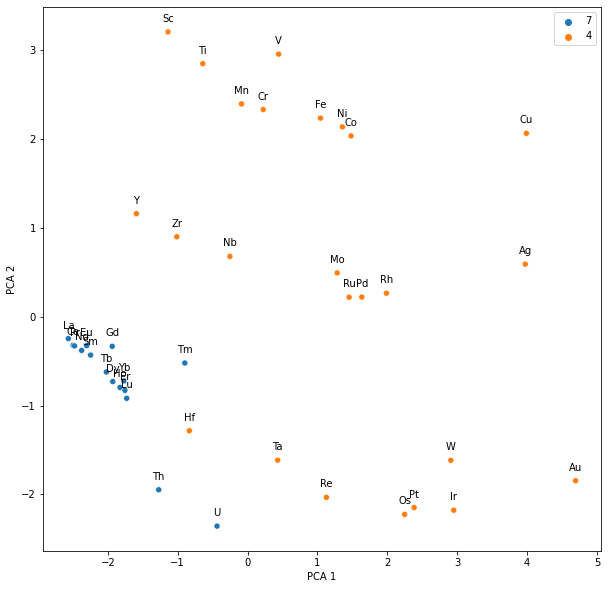

In [159]:
# (4 pts)
# Now, use the code snippet below to plot the 2D PCA plot, where the points are colored according to
# element group and labeled by element name.

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=x, y=y, hue=[str(x) for x in group], ax=ax) 
for x1, y1, label in zip(x, y, element):
        ax.annotate(label, (x1,y1), textcoords='offset points', xytext=(0,10), ha='center')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')

(6 pts) Based on the PCA plot:

* Are any clusters apparent? 
*** Yes, there seems to be 2 tight groups of clusters for group 7 elements, and 2-3 loose clusters for group 4 elements. ***
* What kinds of elements make up these clusters? 
*** These clusters are made up of elements that have similar values for the physical properties (based on eigenvector). For example, the far left tight cluster (blue) for group 7, has La, Eu, Nd, Sm... which all have values for the examined properties that are close to each other. ***
* Are there any elements that appear to be outliers with respect to their element group? *** Group 4 elements seem to be scattered throughout the PCA plot. Group 7 elements are observed to have tight clustering. So, the elements Th, U, Tm, and possibly Gd, appear to be outliers with respect to their group. ***

## Analysis 3: K-means clustering for binary classification

k-means clustering is an unsupervised machine learning method that can be used for classification according to cluster membership.

We could perform k-means cluster analysis on the PCA data that we generated above. In fact, for high dimensional data, it is standard practice to perform dimensionality reduction via PCA or another method before applying k-means. However, our data is only 8-dimensional, so we can apply k-means directly. Our goal will be to find the two best clusters and determine whether they correspond to our two classes of elements.

In [160]:
# For the classification tasks, we will continue to consider only the rare earth metals (group 7) 
# and transition metals (group 4); these data are contained in the ElementsDataSubset.csv file. 

# You have already created the array of normalized feature values, and you will continue to use it
# in this analysis.

# Perform k-means on the normalized features, searching for 2 clusters
kmeans = KMeans(n_clusters=2).fit(featuresT)


# (2 pts)
# Print the two 8D cluster centers selected
centers = kmeans.cluster_centers_
center1 = centers[0]
center2 = centers[1]
print(center1)
print(center2)


[-0.80597802 -0.535302   -0.55352172 -0.20581021  0.23902272  0.7217673
 -0.46801001 -0.7798719 ]
[ 0.93323771  0.61982337  0.64091989  0.23830656 -0.27676315 -0.83573056
  0.54190632  0.90300957]


In [155]:
# (4 pts)
# create and display a three column array or table where the left column is the element name, the middle
# column is the element group, and the right column is the k-means cluster label
label = kmeans.labels_
totalNum = len(element)
table = np.empty((totalNum, 3),dtype=np.object)
for i in range(totalNum):
    table[i][0] = element[i]
    table[i][1] = group[i]
    table[i][2] = label[i]
print(table)


[['La' 7 0]
 ['Ce' 7 0]
 ['Pr' 7 0]
 ['Nd' 7 0]
 ['Sm' 7 0]
 ['Eu' 7 0]
 ['Gd' 7 0]
 ['Tb' 7 0]
 ['Dy' 7 0]
 ['Ho' 7 0]
 ['Er' 7 0]
 ['Tm' 7 0]
 ['Yb' 7 0]
 ['Lu' 7 0]
 ['Th' 7 0]
 ['U' 7 0]
 ['Sc' 4 0]
 ['Ti' 4 0]
 ['V' 4 1]
 ['Cr' 4 1]
 ['Mn' 4 1]
 ['Fe' 4 1]
 ['Co' 4 1]
 ['Ni' 4 1]
 ['Cu' 4 1]
 ['Y' 4 0]
 ['Zr' 4 0]
 ['Nb' 4 0]
 ['Mo' 4 1]
 ['Ru' 4 1]
 ['Rh' 4 1]
 ['Pd' 4 1]
 ['Ag' 4 1]
 ['Hf' 4 0]
 ['Ta' 4 0]
 ['W' 4 1]
 ['Re' 4 1]
 ['Os' 4 1]
 ['Ir' 4 1]
 ['Pt' 4 1]
 ['Au' 4 1]]


(12 pts) Looking at the agreement between the group number and the cluster number, answer the following questions:

* In which cluster is the element La? 
** The element La is in the first cluster, cluster 0. **

* Which cluster corresponds to transition metals (group 4)? 
** The transition metals (group 4), has elements that correspond to both clusters. Around 9 are in cluster 0 and around 15 are in cluster 1. There are more elements in group 4 that correspond to cluster 1, so group 4 is supposed to correspond to cluster 1. **

* What is the classification accuracy (true positives/total data points)? 
** There are 16 true positives and 41 total data points. The classification accuracy is 16/41 = 39.02%. **
** The confusion matrix gives 16 true negatives, 0 false positives, 9 false negatives, and 16 true positives (0 = group 7, 1 = group 4). **

* What is the precision (true positives/all positives) for group 4? 
Group 7? 
** For group 4, there are 16 true positives and 0 false positives, so the precision is 16/16 = 100%. For group 7, the precision is 16/25 = 64% (examine negatives). **

* What is the recall (true positives/(true positives + false negatives)) for group 4?
Group 7? 
** For group 4, the recall is 16/(16 + 9) = 64%. For group 7, the recall is 16/(16 + 0) = 100%. **

* Determine which elements were misclassified as rare earth metals (group 7). Do the misclassifications make physical sense, given what you know about the periodic table? 
** The elements that were misclassified as rare earth metals (group 7) are:
Sc, Ti, V, Cr, Mn, Y, Zr, Nb, and Hf. It makes physical sense since the periodic table groups are determined by elements with similar valence electronic behavior, and the transition metals mentioned could have varying valence electrons. **

Now run k-means again. The random number seed will be different, so the results may change.

(2 pts) Did the accuracy increase, decrease or stay the same? *** The accuracy increased; there are now 18 true positives out of 41 data points. ***

Because results can change depending on the random selection of initial cluster centers, k-means is often run many times, and the best result is selected.

## Analysis 4: Support Vector Machine (SVM) classification

Now we will train a supervised machine learning method, support vector machine (SVM), to classify our elements. Our goal will be to train the classifier on some of the data, and see how well it can predict the element group for the remaining unseen data.

In [161]:
# The element group is our "ground truth" - it is what we want to predict. 
# Once again, we will operate on our an array of normalized features and a vector of element group values. 
# (You should have already defined these above.)

# (2 pts)
# Use train_test_split to split your data into a 50/50 training data and test data split.
# Print the total number of test elements and the number of group 4 elements contained in the test set.
featuresSVM = copy.deepcopy(featuresT)
(trainF, testF, trainG, testG) = train_test_split(featuresSVM, group, test_size=0.5)
print(len(testF))
group4 = 0
for n in testG:
    if n == 4:
        group4 += 1
print(group4)


21
14


In [162]:
# Train sklearn's support vector classifier (SVC) class with a linear kernel to 
# perform SVM classification on your training data.
clf = SVC(kernel='linear')
clf.fit(trainF, trainG)


SVC(kernel='linear')

In [164]:
# (2 pts)
# Print the vector of element group labels (ground truth) for the test data set
# and the predicted element group labels for the test data set.

# The goal, of course, is for the two vectors to be the same.
groundTruthGroup = np.array(testG)
print(groundTruthGroup)
predictGroup = clf.predict(testF)
print(predictGroup)


[7 4 7 7 7 4 4 4 4 7 4 4 4 4 7 4 4 4 7 4 4]
[7 4 7 7 7 4 4 7 4 7 4 4 4 4 7 4 4 4 7 4 4]


In [167]:
# The sklearn.metrics confusion_matrix and classification_report calculate helpful metrics
# for the SVM classification. 

# (2 pts)
# Run both modules and print the results.
confusionMatrix = confusion_matrix(groundTruthGroup, predictGroup)
classReport = classification_report(groundTruthGroup, predictGroup)
print(confusionMatrix)
print(classReport)
tn, fp, fn, tp = confusion_matrix(groundTruthGroup, predictGroup).ravel()
print(tp)
print(testF[7])

[[13  1]
 [ 0  7]]
              precision    recall  f1-score   support

           4       1.00      0.93      0.96        14
           7       0.88      1.00      0.93         7

    accuracy                           0.95        21
   macro avg       0.94      0.96      0.95        21
weighted avg       0.96      0.95      0.95        21

7
[-0.88595469 -0.57157926 -0.58578109  0.4035811  -0.78853419  0.48862125
 -1.16573285 -0.49293068]


(10 pts) Based on your results above, answer the following questions:

* What is the overall classification accuracy? 
*** The overall classification accuracy is defined as number of true positives out of total data points. There are 7 true positives and 21 total data points; 7/21 = 33.3%. (accuracy of f1-score is 95%; if accuracy is defined as % of correct predictions, accuracy = 20/21 = 95%).  ***

* How many group 4 elements were classified as group 7? 
*** Only 1 group 4 element was classified as group 7. ***

* What is the precision for group 4? ** The precision for group 4 is 1.00 = 100%. **<br>
Group 7? ** The precision for group 7 is 0.88 = 88%. **

* What is the recall for group 4? ** The recall for group 4 is 0.93 = 93%. **<br>
Group 7? ** The recall for group 7 is 1.00 = 100%. **

* Determine which elements, if any, were misclassified as rare earth metals (group 7). Do the misclassifications make physical sense, given what you know about the periodic table? ** Only 1 element was misclassified as group 7 (rare earth metals): Y. Yes, the misclassification makes physical sense. Because of its differing oxidation states, the valence electrons differ and lead to misclassifications.  **

(6 pts) Choose another train/test split that uses more training data, and run SVM again. Report the new test/train split: ** training data size/test data size = 0.75 **

* Did the accuracy increase, decrease or stay the same? 
** The accuracy increased; 100% was predicted correctly in test data. **

* Does that make sense, considering the increase in the amount of training data?  
**Yes, the accuracy is expected to increase since we have more training data and the model can have more data to learn. **

Because results can change depending on the choice of test data (especially for small data sets like ours), SVM is often run using cross-validation, which uses multiple train/test splits and averages the results.

In [172]:
## SVM 2ND RUN WITH NEW TRAIN/TEST SPLIT WITH TRAINING DATA SIZE = 0.75

featuresSVM1 = copy.deepcopy(featuresT)
(trainF1, testF1, trainG1, testG1) = train_test_split(featuresSVM1, group, test_size=0.25)
print(len(testF1))
#group4 = 0
#for n in testG:
#    if n == 4:
#        group4 += 1
#print(group4)

clf1 = SVC(kernel='linear')
clf1.fit(trainF1, trainG1)

groundTruthGroup1 = np.array(testG1)
print(groundTruthGroup1)
predictGroup1 = clf1.predict(testF1)
print(predictGroup1)


11
[4 4 4 7 4 4 7 7 7 4 4]
[4 4 4 7 4 4 7 7 7 4 4]
